# Hidden Markov Model (HMM)

In [6]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['figure.figsize'] = (15, 5)

### Markov Model

* Random stochastic transitions between a set of discrete states, with each transition ocurring at an average rate.
* *Memoryless*: Next transition depends only on the current state, not the past history.

### Hidden Markov Model

* We don't observe the states directly, but instead we observe a probabilistic output (emission) from each state.
* Observations are random variables from probability distributions that may differ for each state.

![HMM](images/hmm.png)

The probability of getting a particular sequence of observations $O_1, O_2, ...$ is given by

### $\begin{align}
P(O_1, O_2, ...) &= \sum_{S_1, S_2, ...} P(S_1) P(S_1 \rightarrow O_1) P(S_1 \rightarrow S_2)  P(S_2 \rightarrow O_2) P(S_2 \rightarrow S_3)  P(S_3 \rightarrow O_3) ... \\
                 &= \sum_{S_1, S_2, ...} P(S_1) P(S_1 \rightarrow O_1) \prod_{i \geq 2} P(S_{i-1} \rightarrow S_i)  P(S_i \rightarrow O_i)
\end{align}$

---
# 2-State Model

### $State 0 \rightleftarrows State 1$

---
## State Sequence

## <font color=blue>Learning Objectives:</font>
1. You will understand how to generate a state sequence from a starting probability vector `p0` and transition probability matrix `A`.

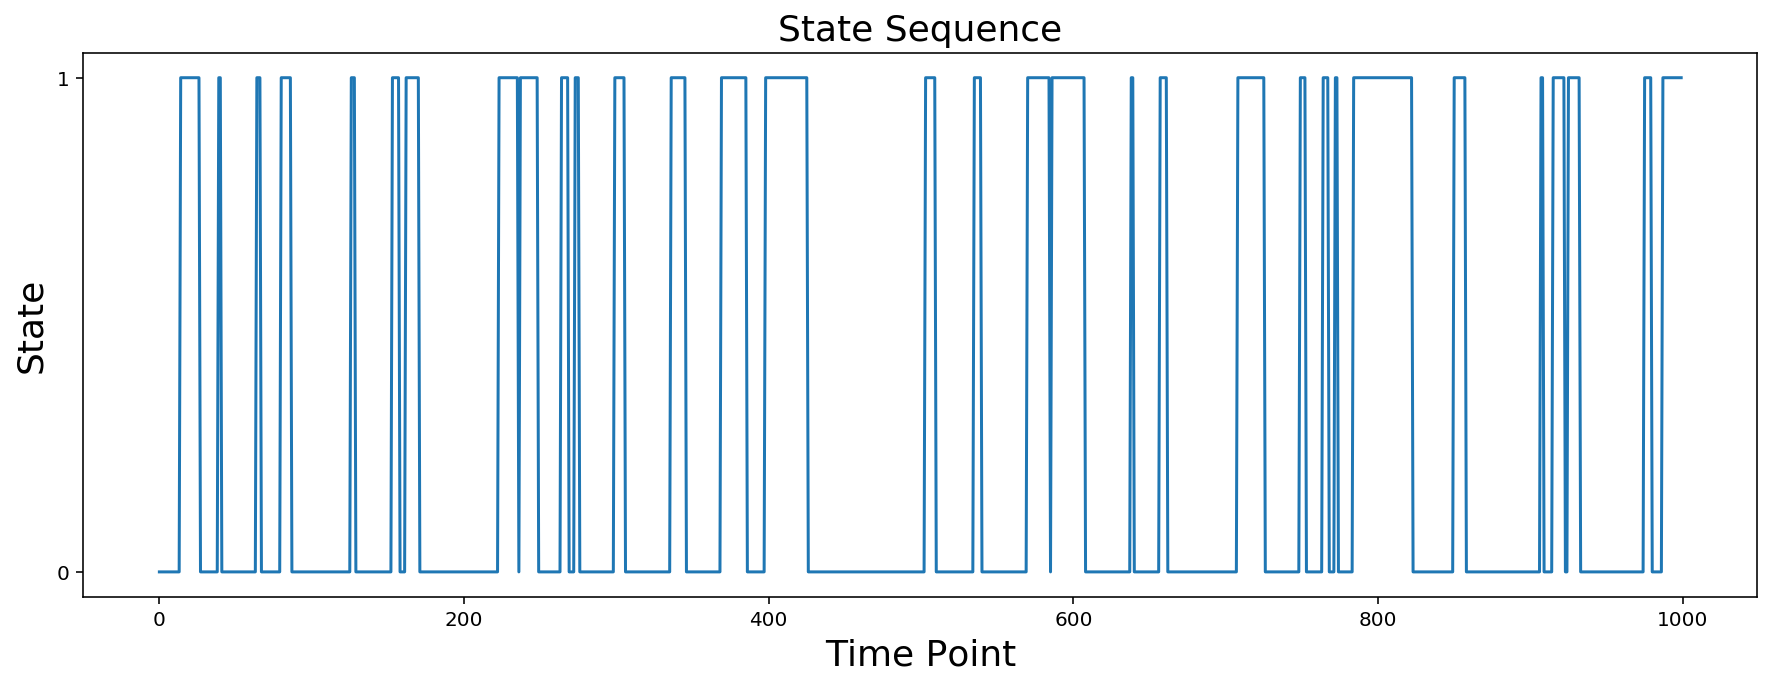

In [7]:
# transition probability matrix for each time step
# A[i,j] is transition probability from state i to state j
A = np.array([[0.95, 0.05],   # P(state0->state0), P(state0->state1)
              [0.10, 0.90]])  # P(state1->state0), P(state1->state1)

# initial state probabilities (i.e. probability that we start off in each state)
# p0[i] is the probability of starting in state i
p0 = np.array([0.99, 0.01])     # P(state0), P(state1)

# memory for state sequence of 1000 time points
state_seq = np.zeros(1000, dtype=int)

# set initial state by drawing from initial state probability array
state_seq[0] = np.random.choice([0, 1], p=p0)

# for each subsequent time point, set the state based on the transition probabilities out of the current state
for t in range(len(state_seq)-1):
    state = state_seq[t]
    state_seq[t+1] = np.random.choice([0, 1], p=A[state,:])

# plot the state sequence
plt.plot(state_seq)
plt.yticks([0, 1])
plt.xlabel('Time Point')
plt.ylabel('State')
plt.title('State Sequence');

## <font color=red>Exercises</font>

1. In the transition matrix `A` above, set the probability of transitioning from state 0 to state 1 to 0.05 and resimulate the state sequence.
2. In the starting probability vector `p0` above, set the starting probability for state 0 to 0.99 and resimulate the state sequence several times.

---
## Hidden State Sequence $\rightarrow$ Observed Sequence

Let's assume the state sequence is not directly observable.

Instead each state emits a random variable that we observe.

State 0 emits a value with mean 0 and standard deviation 1.

State 1 emits a value with mean 5 and standard deviation 1.

## <font color=blue>Learning Objectives:</font>
1. You will understand how to generate random observations from an underlying hidden state sequence.

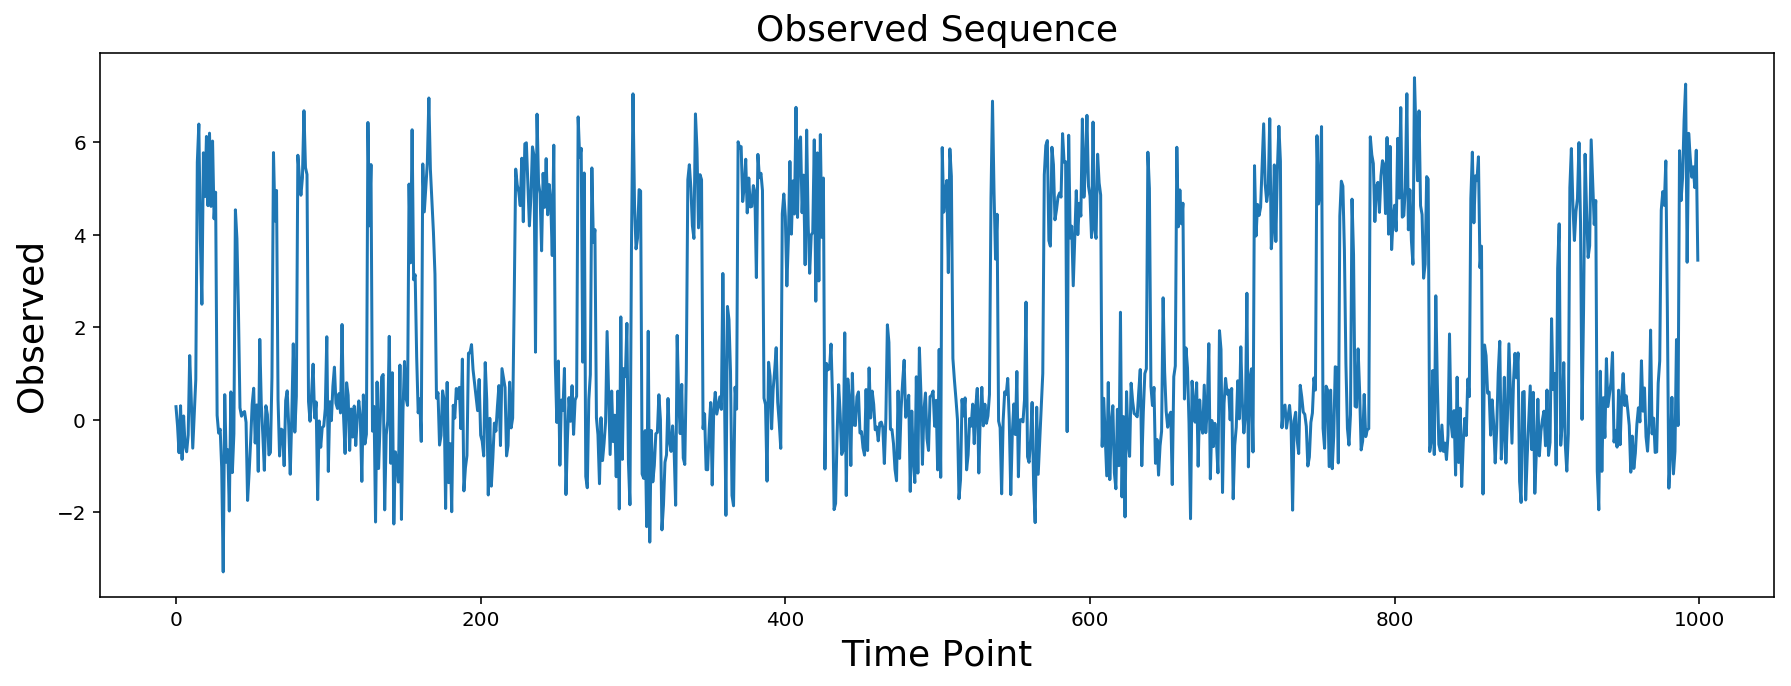

In [8]:
# emission probability distributions for each state
# state_emission_pds[i] is the emission probability distribution for state i
state_emission_pds = [st.norm(0, 1), st.norm(5, 1)]

# memory for observation sequence
observed_seq = np.zeros(state_seq.shape)

# for each state in the sequence, generate an observed emission value
for t in range(len(state_seq)):
    state = state_seq[t]
    observed_seq[t] = state_emission_pds[state].rvs()

# plot the observed sequence
plt.plot(observed_seq)
plt.xlabel('Time Point')
plt.ylabel('Observed')
plt.title('Observed Sequence');

## <font color=red>Exercises</font>

1. Change the emission probability distribution for state 1 to an exponential distribution with loc=5 and scale=4. Resimulate the observed sequence.
2. Change the emission probability distribution for state 1 back to the original normal distribution with mean 5 and standard deviation 1. Resimulate the observed sequence.

---
## Let's repeat the computation of the observed sequence in a much more efficient manner.

## <font color=blue>Learning Objectives:</font>
1. You will recall that performing operations on arrays all at once is much more efficient than iteratively performing the operation on each item in the array sequentially in a loop.
2. You will know how to use `np.where`.

array([ 14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        39,  40,  64,  65,  66,  80,  81,  82,  83,  84,  85,  86, 126,
       127, 128, 153, 154, 155, 156, 157, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 223, 224, 225, 226, 227, 228, 229, 230])

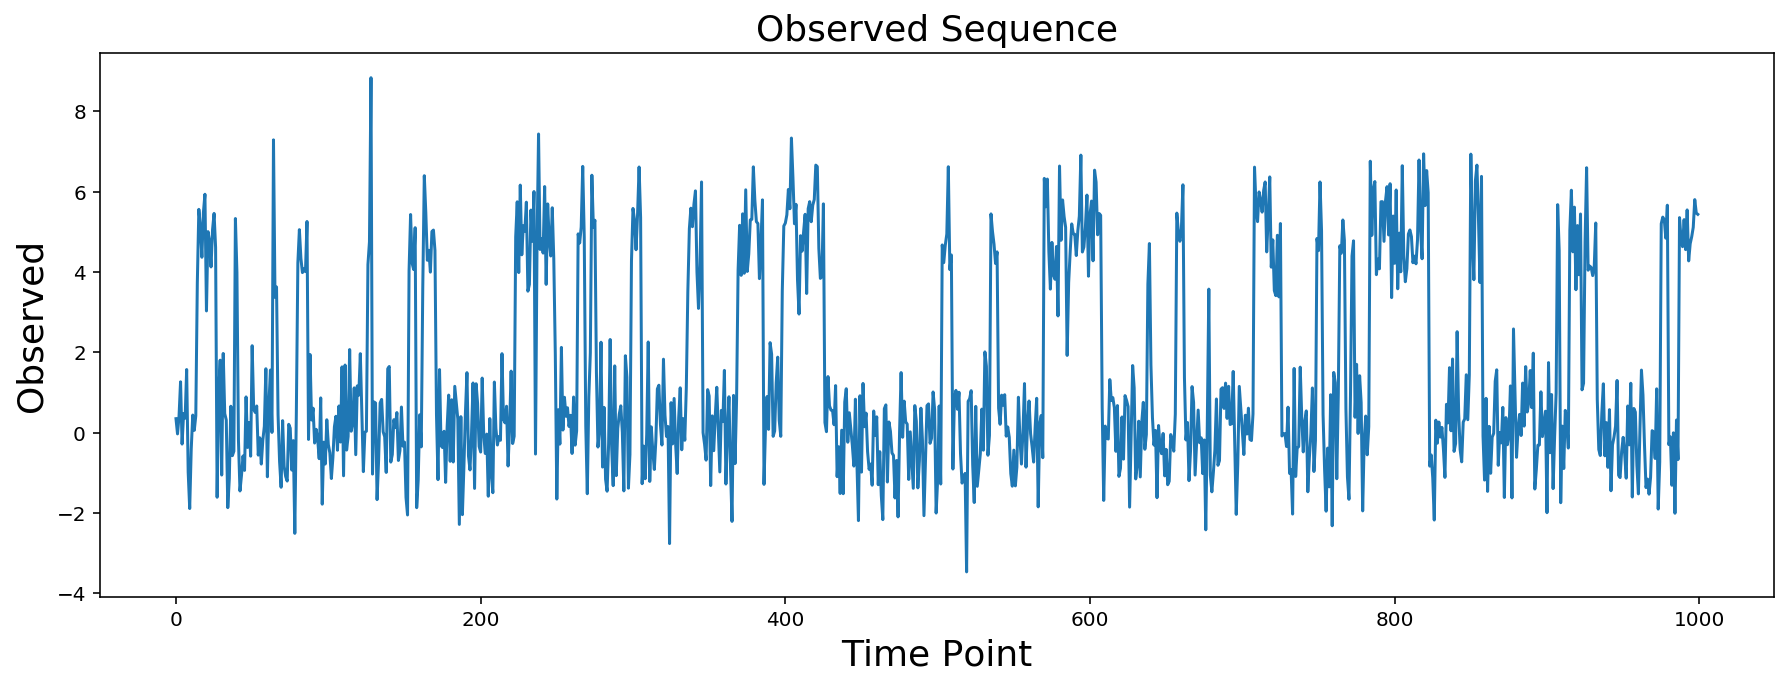

In [9]:
observed_seq = np.zeros(state_seq.shape)

for state in [0, 1]:
    indices = np.where(state_seq == state)[0]
    observed_seq[indices] = state_emission_pds[state].rvs(len(indices))

plt.plot(observed_seq)
plt.xlabel('Time Point')
plt.ylabel('Observed')
plt.title('Observed Sequence');

indices[:50]

## <font color=red>Exercises</font>

1. Given only the observed sequence, do you think you could determine the hidden state sequence with reasonable accuracy?
2. Plot a histogram of the observed values across the entire sequence.
3. How would you estimate the emission probability distributions (mean and standard deviation) for each state?

---
## Threshold Idealization

## <font color=blue>Learning Objectives:</font>
1. You will be able to use threshold(s) to segregate observations into states by amplitude.
2. You will be able to visualize predicted states by color coding your data points.

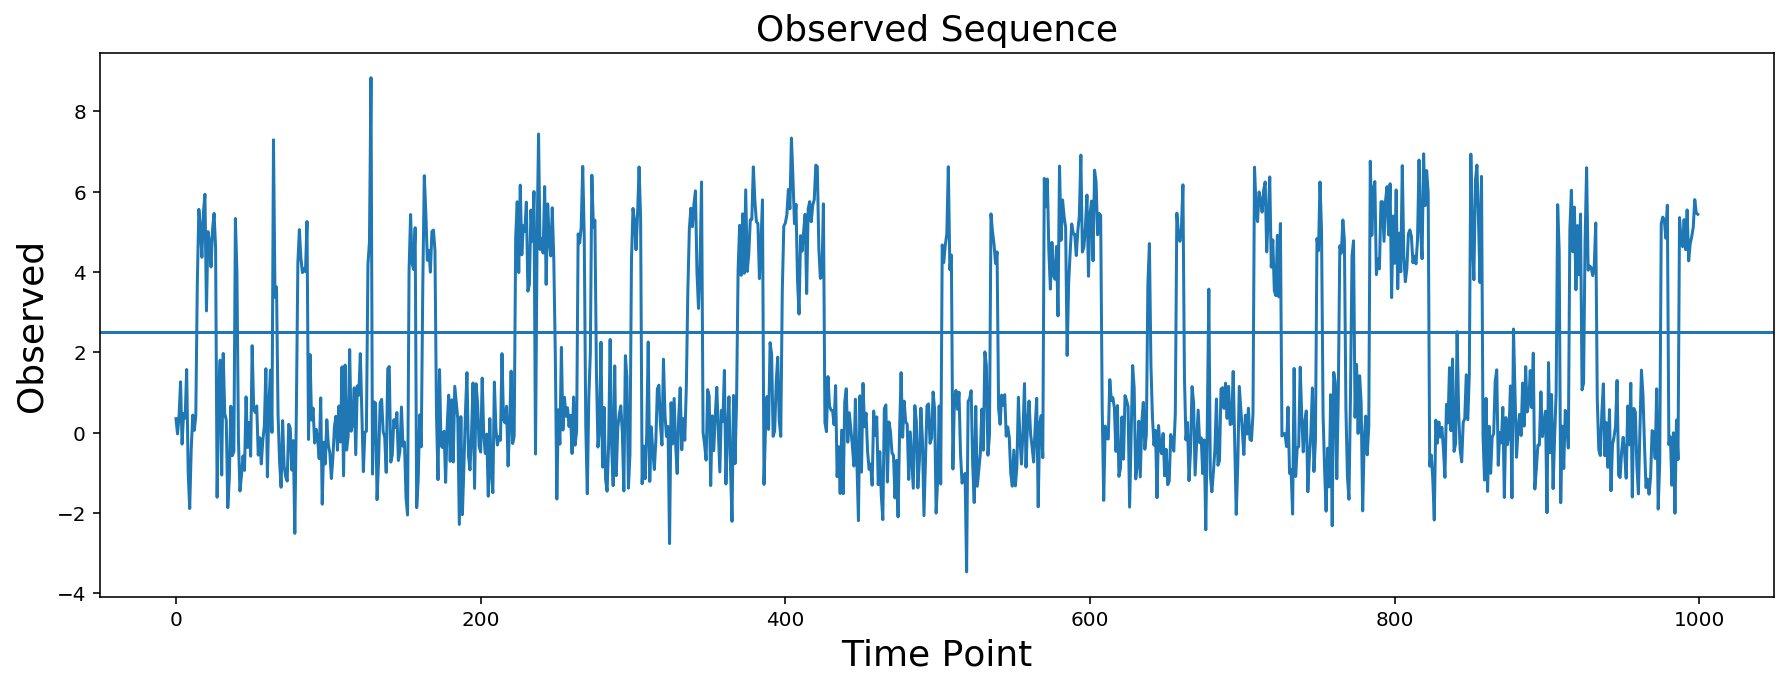

In [10]:
threshold = 2.5

plt.plot(observed_seq)
plt.axhline(threshold)
plt.xlabel('Time Point')
plt.ylabel('Observed')
plt.title('Observed Sequence');

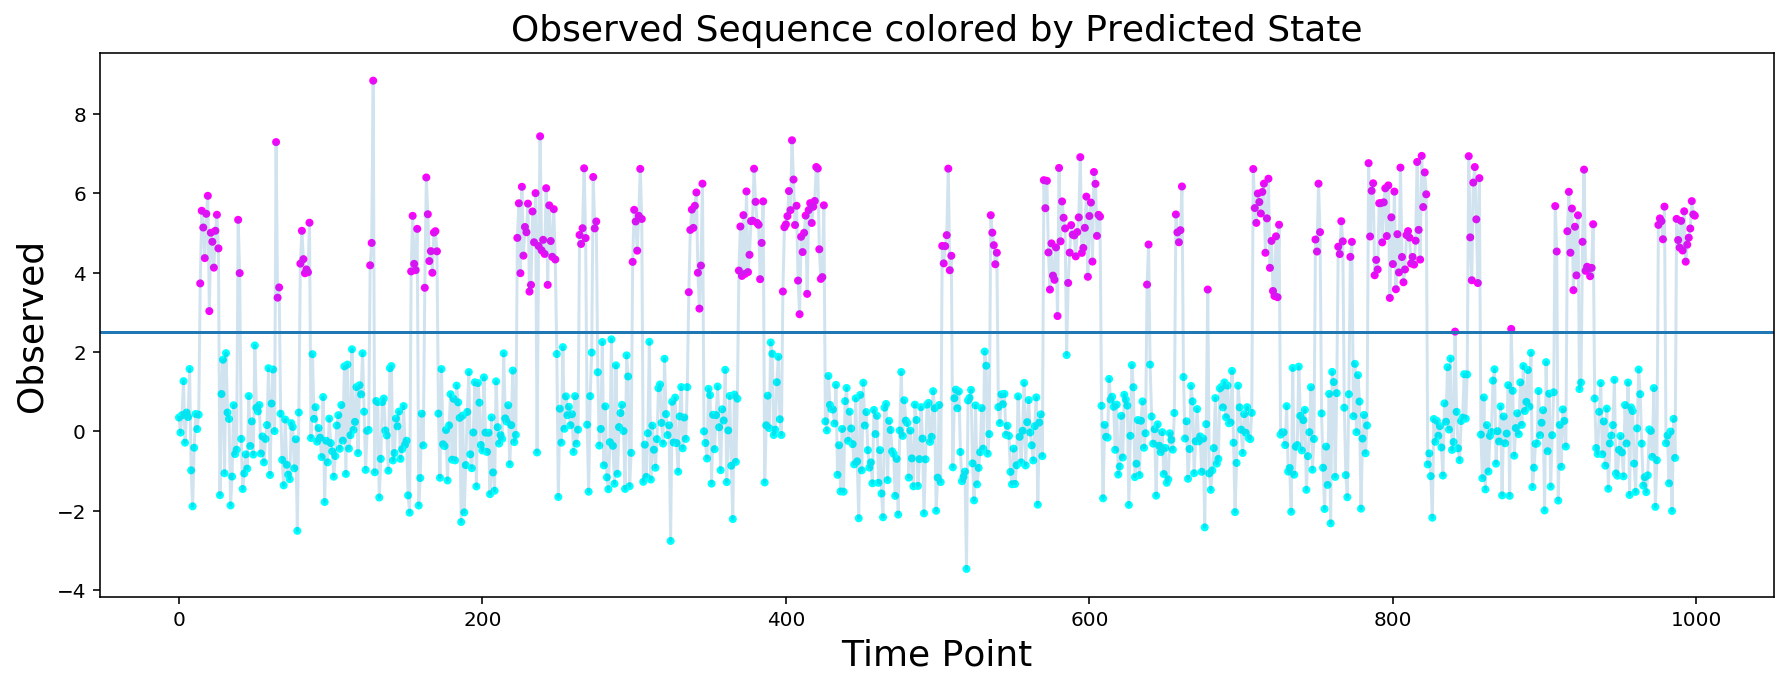

In [11]:
# memory for predicted state sequence
predicted_state_seq = np.zeros(observed_seq.shape, dtype=int)

# predict state sequence using threshold idealization
state0_indices = np.where(observed_seq < threshold)[0]
state1_indices = np.where(observed_seq >= threshold)[0]

predicted_state_seq[state0_indices] = 0
predicted_state_seq[state1_indices] = 1

# plot the observed sequence
# with data points colored by their predicted state
plt.plot(observed_seq, alpha=0.2)
plt.scatter(range(len(observed_seq)), observed_seq, marker='.', c=predicted_state_seq, cmap='cool')
plt.axhline(threshold)
plt.xlabel('Time Point')
plt.ylabel('Observed')
plt.title('Observed Sequence colored by Predicted State');

### Find all the points that were incorrectly assigned the wrong state in our prediction.

* Normally, you don't know this because you only have the observations and don't know the true state sequence.
* In this case we do know it because we simulated the data.

*This is ONLY to give you a visualization of the performance of the threshold idealization.*

In [12]:
wrong_indices = np.where(predicted_state_seq - state_seq != 0)[0]
wrong_indices

array([678, 841, 878])

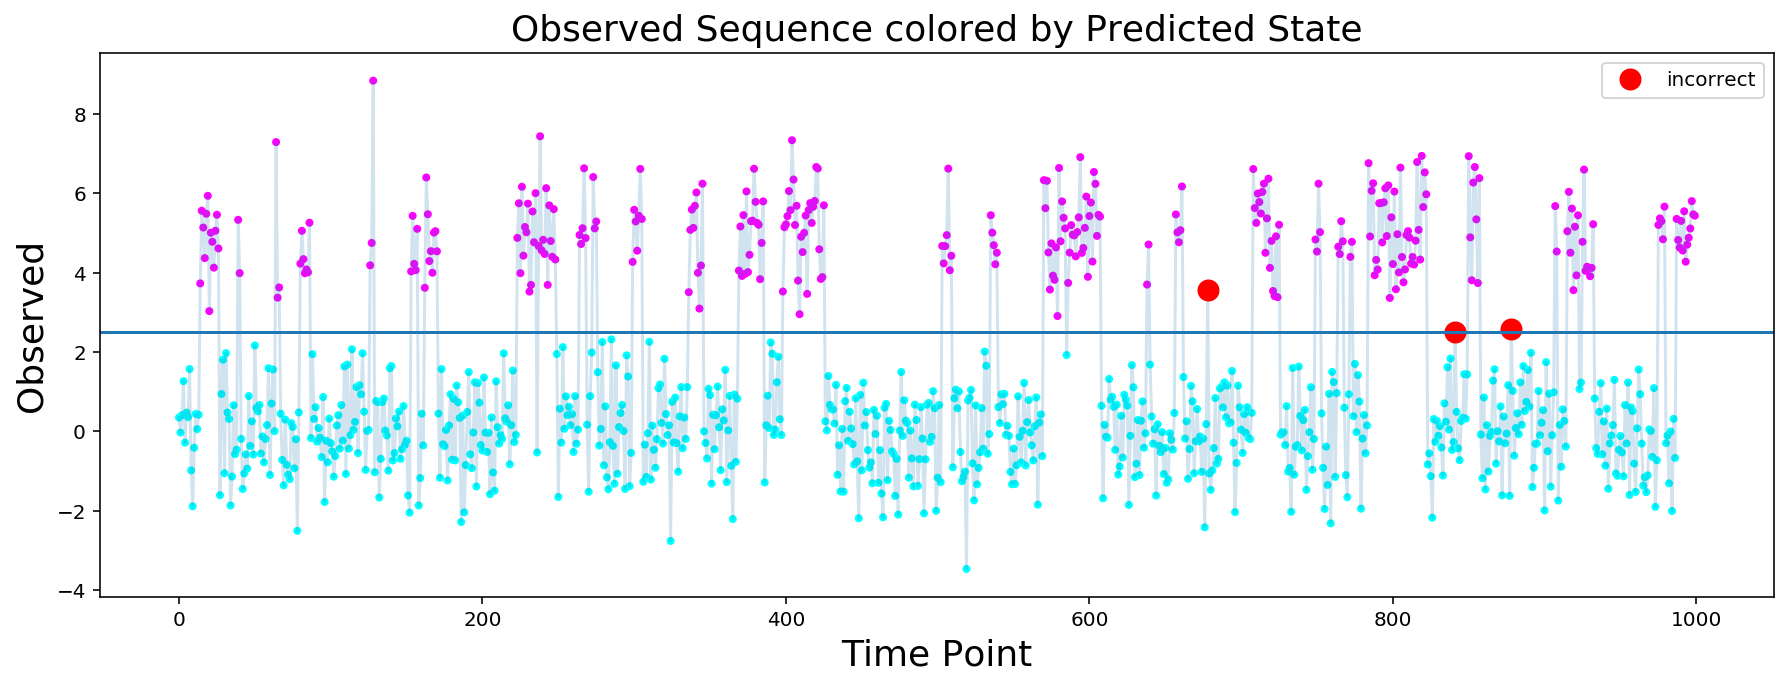

In [13]:
plt.plot(observed_seq, alpha=0.2)
plt.scatter(range(len(observed_seq)), observed_seq, marker='.', c=predicted_state_seq, cmap='cool')
plt.plot(wrong_indices, observed_seq[wrong_indices], 'ro', ms=10, label='incorrect')
plt.axhline(threshold)
plt.xlabel('Time Point')
plt.ylabel('Observed')
plt.title('Observed Sequence colored by Predicted State');
plt.legend();

## <font color=red>Exercises</font>

1. Use `np.where` to find the indices of all the observed data points between 2 and 3.
2. Plot the observed sequence as a line, and plot the points between 2 and 3 as colored symbols.

In [44]:
inbetween2and3 = np.where((observed_seq >= 2) & (observed_seq <= 3))[0]
inbetween2and3

array([ 50, 114, 253, 279, 285, 310, 390, 409, 531, 579, 841, 878])

---
## Filtering and Missed Events

## <font color=blue>Learning Objectives:</font>
1. You will understand how filtering of a noisy observed sequence affects your prediction of the underlying state sequence.

Sample frequency = 10.0 kHz


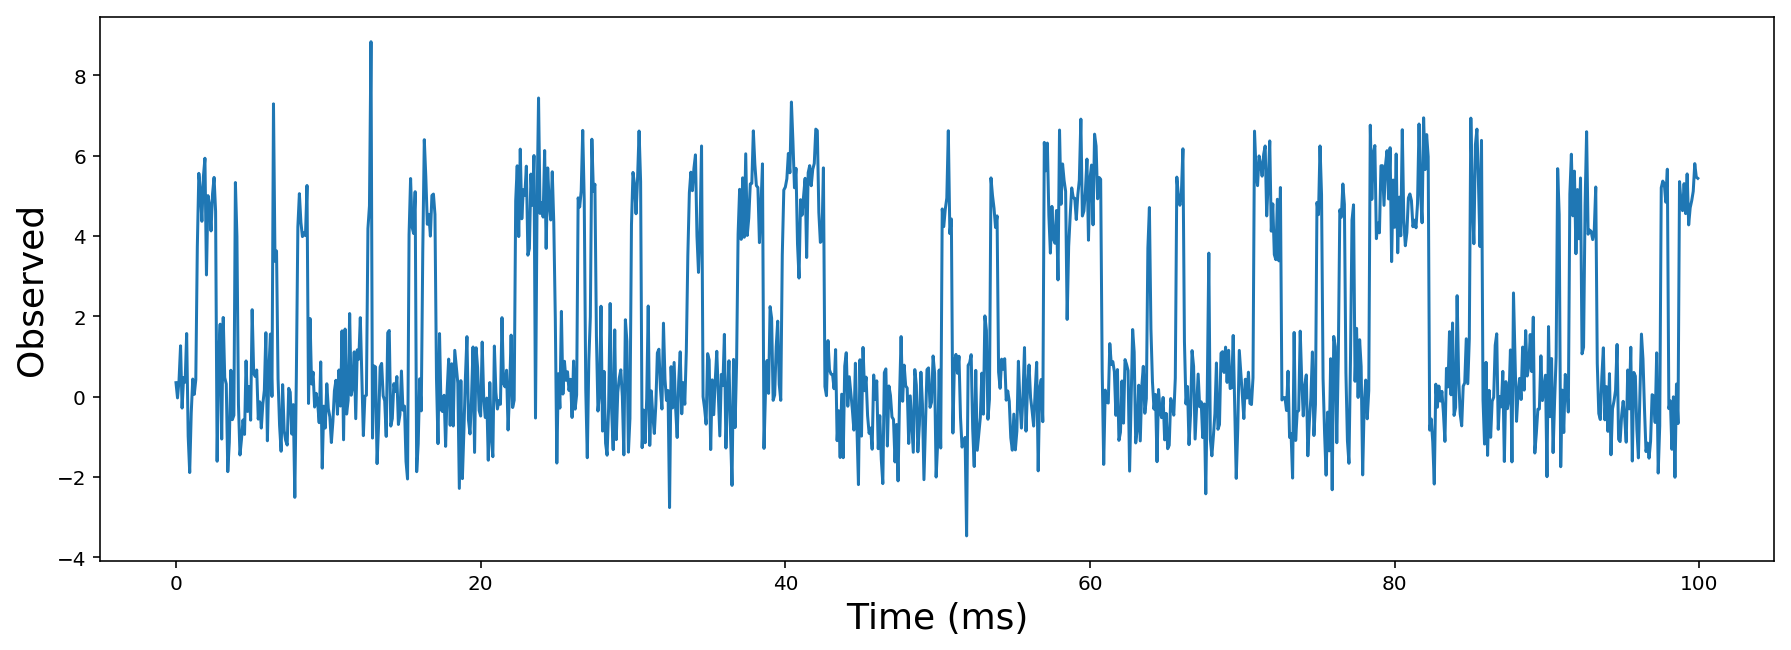

In [31]:
# Assign time values instead of time step indices.
sample_interval_ms = 0.1  # 100 us
sample_frequency_kHz = 1 / sample_interval_ms

print(f'Sample frequency = {sample_frequency_kHz} kHz')

time_ms = np.arange(len(observed_seq)) * sample_interval_ms

plt.plot(time_ms, observed_seq)
plt.xlabel('Time (ms)')
plt.ylabel('Observed');

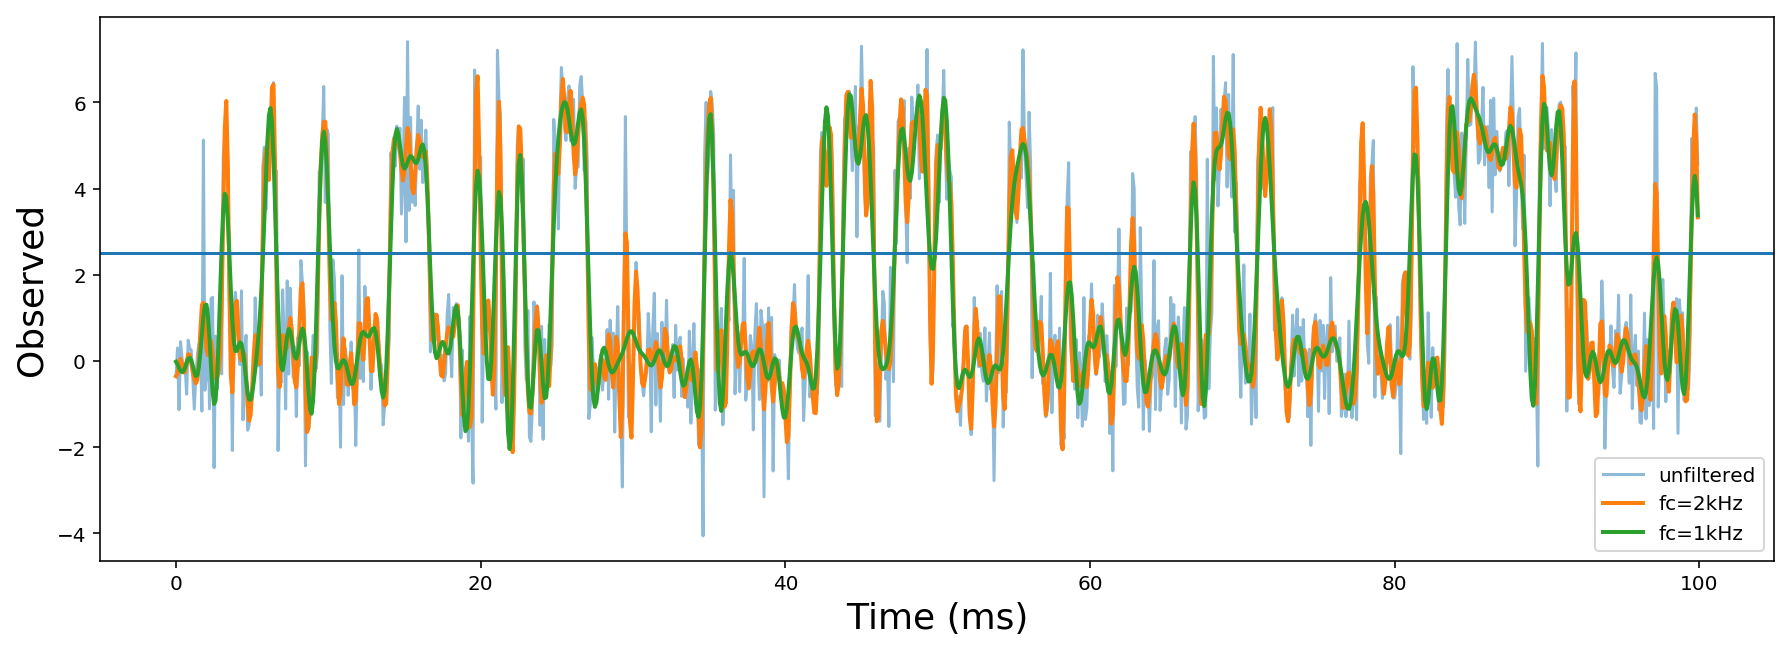

In [76]:
from scipy import signal

lowpass2kHz = signal.firwin(301, 2, nyq=sample_frequency_kHz/2)
lowpass1kHz = signal.firwin(301, 1, nyq=sample_frequency_kHz/2)

filtered2kHz_seq = np.convolve(observed_seq, lowpass2kHz, 'same')
filtered1kHz_seq = np.convolve(observed_seq, lowpass1kHz, 'same')

plt.plot(time_ms, observed_seq, alpha=0.5, label='unfiltered')
plt.plot(time_ms, filtered2kHz_seq, lw=2, label='fc=2kHz')
plt.plot(time_ms, filtered1kHz_seq, lw=2, label='fc=1kHz')
plt.axhline(threshold)
plt.xlabel('Time (ms)')
plt.ylabel('Observed');
plt.legend();

## <font color=red>Exercises</font>

1. Can you find an instance in the above plot where filtering would cause an error in state identificaiton for threshold idealization?
2. Can you find an instance in the above plot where filtering would fix an error in state identificaiton for threshold idealization?

---
## Gaussian Mixture Model (GMM)

Recall that we did previously this by rolling our own Gaussian mixture negative loglikelihood function and optimizing it.

**What a pain that was!**

Since mixtures of Gaussians are used quite often, there's a package that can handle all of that for us.

**Thank goodness!**

## <font color=blue>Learning Objectives:</font>
1. You will be able to easily describe a distribution as a weighted mixture of Gaussin (normal) distributions.

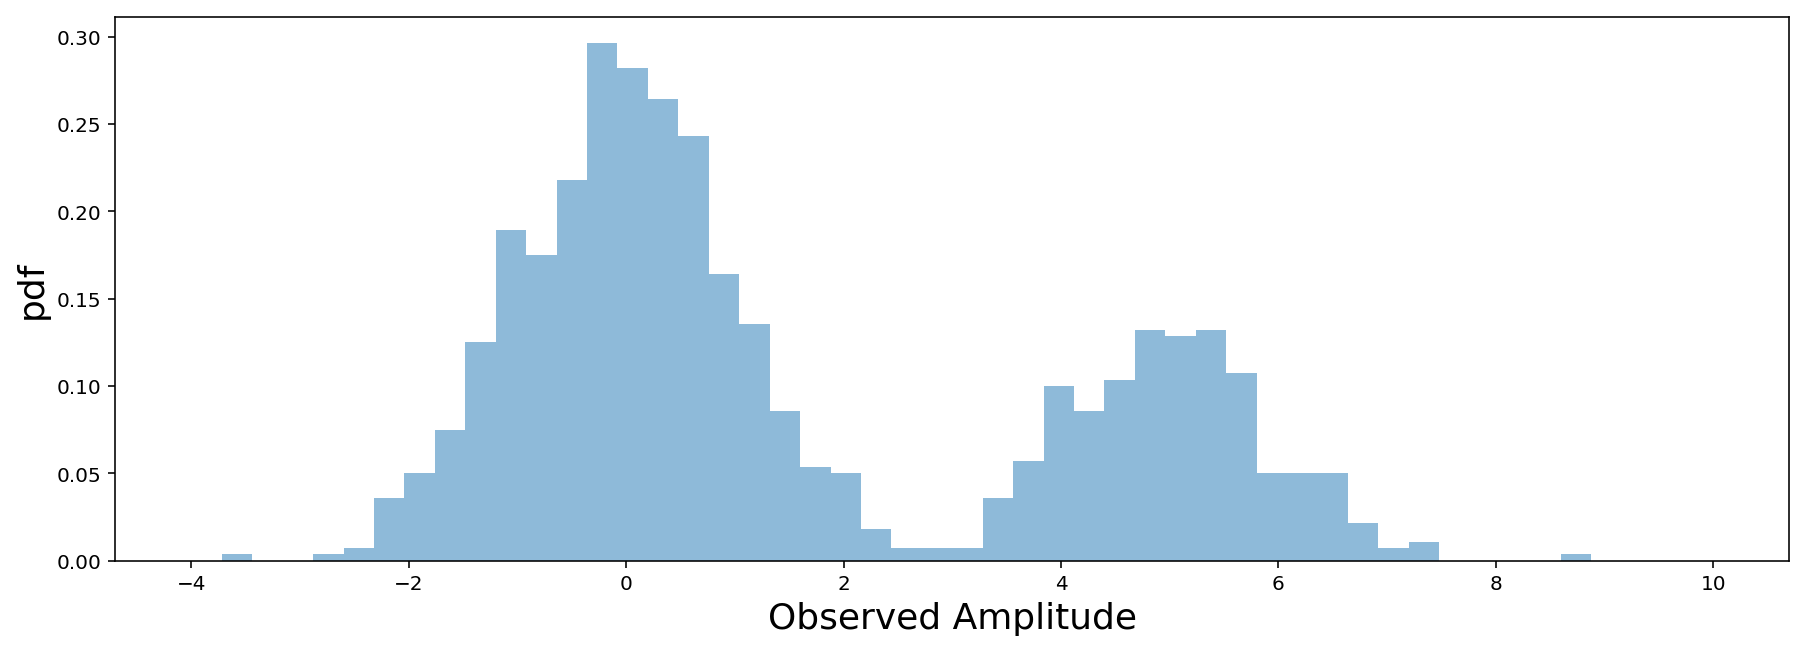

In [20]:
binEdges = np.linspace(-4, 10, 51)  # 51 edges -> 50 bins
plt.hist(observed_seq, bins=binEdges, alpha=0.5, density=True)
plt.xlabel('Observed Amplitude')
plt.ylabel('pdf');

In [21]:
# conda install -c intel scikit-learn
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=1)
gmm.fit(observed_seq.reshape(-1, 1))

gmm

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=1, precisions_init=None,
                random_state=1, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [22]:
# Fractions of each individual Gaussian in the GMM
# that are added to the overall pdf.
gmm.weights_

array([0.69450231, 0.30549769])

In [23]:
# Means of each individual Gaussian in the GMM.
gmm.means_

array([[-0.03090642],
       [ 5.01352442]])

In [24]:
# Matrix of covariances between individual Gaussians in the GMM.
# Diagonal elements are the variances of the individual Gaussians.
gmm.covariances_

array([[[0.97107597]],

       [[0.87602118]]])

In [25]:
# np.squeeze gets rid of any unused dimensions.
np.squeeze(gmm.covariances_)

array([0.97107597, 0.87602118])

In [26]:
# Since we only have variances in this case,
# their sqrt is the standard deviation of each Gaussian in the GMM.
np.sqrt(np.squeeze(gmm.covariances_))

array([0.98543187, 0.93596003])

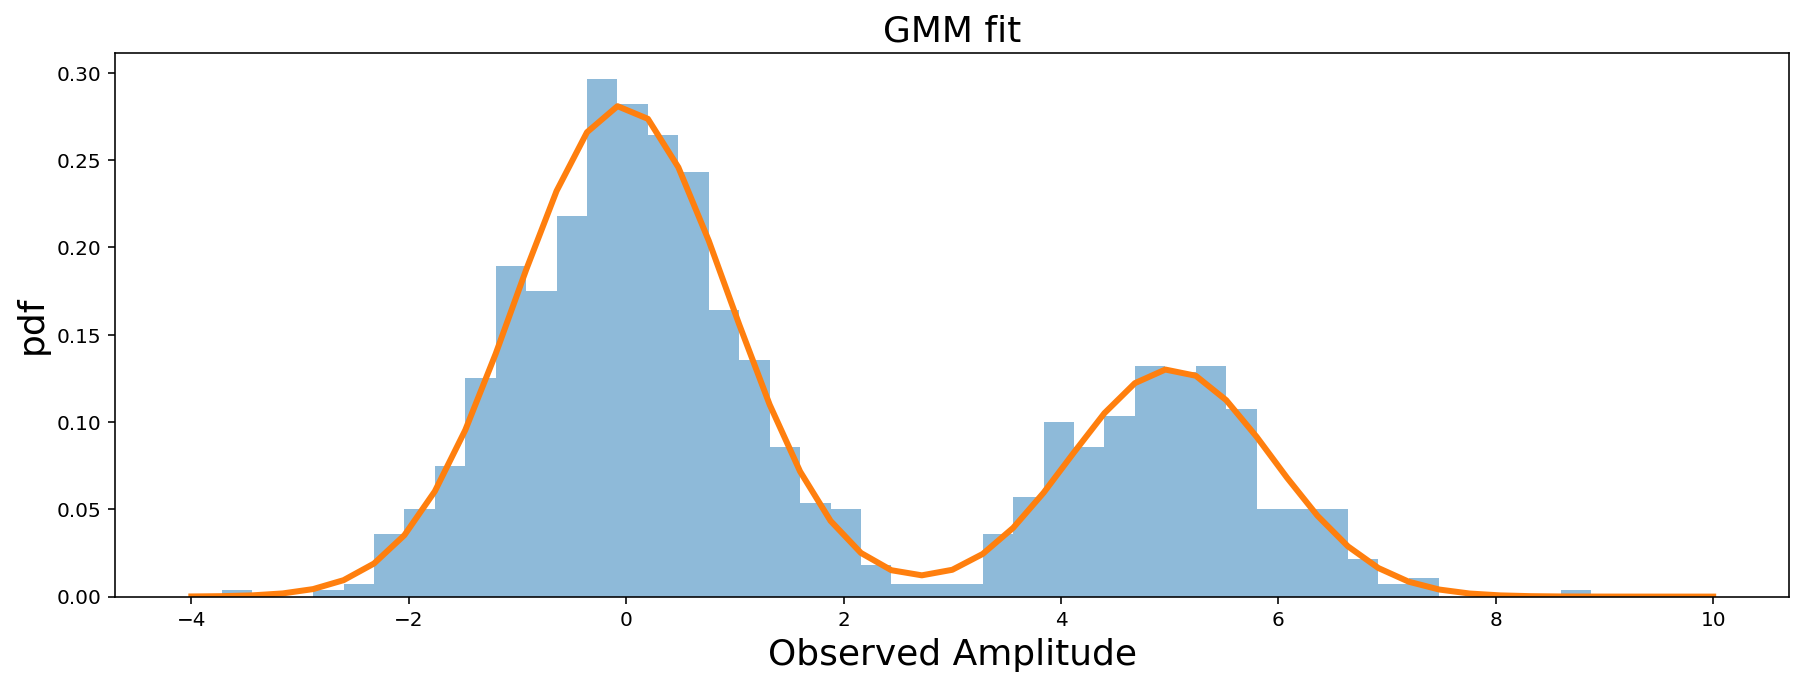

In [27]:
gmm_pdf = np.zeros(binEdges.shape)
for i in range(2):
    weight = gmm.weights_[i]
    mu = np.squeeze(gmm.means_)[i]
    sigma = np.sqrt(np.squeeze(gmm.covariances_)[i])
    gmm_pdf += weight * st.norm.pdf(binEdges, mu, sigma)

plt.hist(observed_seq, bins=binEdges, alpha=0.5, density=True)
plt.plot(binEdges, gmm_pdf, lw=3)
plt.xlabel('Observed Amplitude')
plt.ylabel('pdf')
plt.title('GMM fit');

In [28]:
gmm_predicted_state_seq = gmm.predict(observed_seq.reshape(-1, 1))

print(gmm_predicted_state_seq[:30])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]


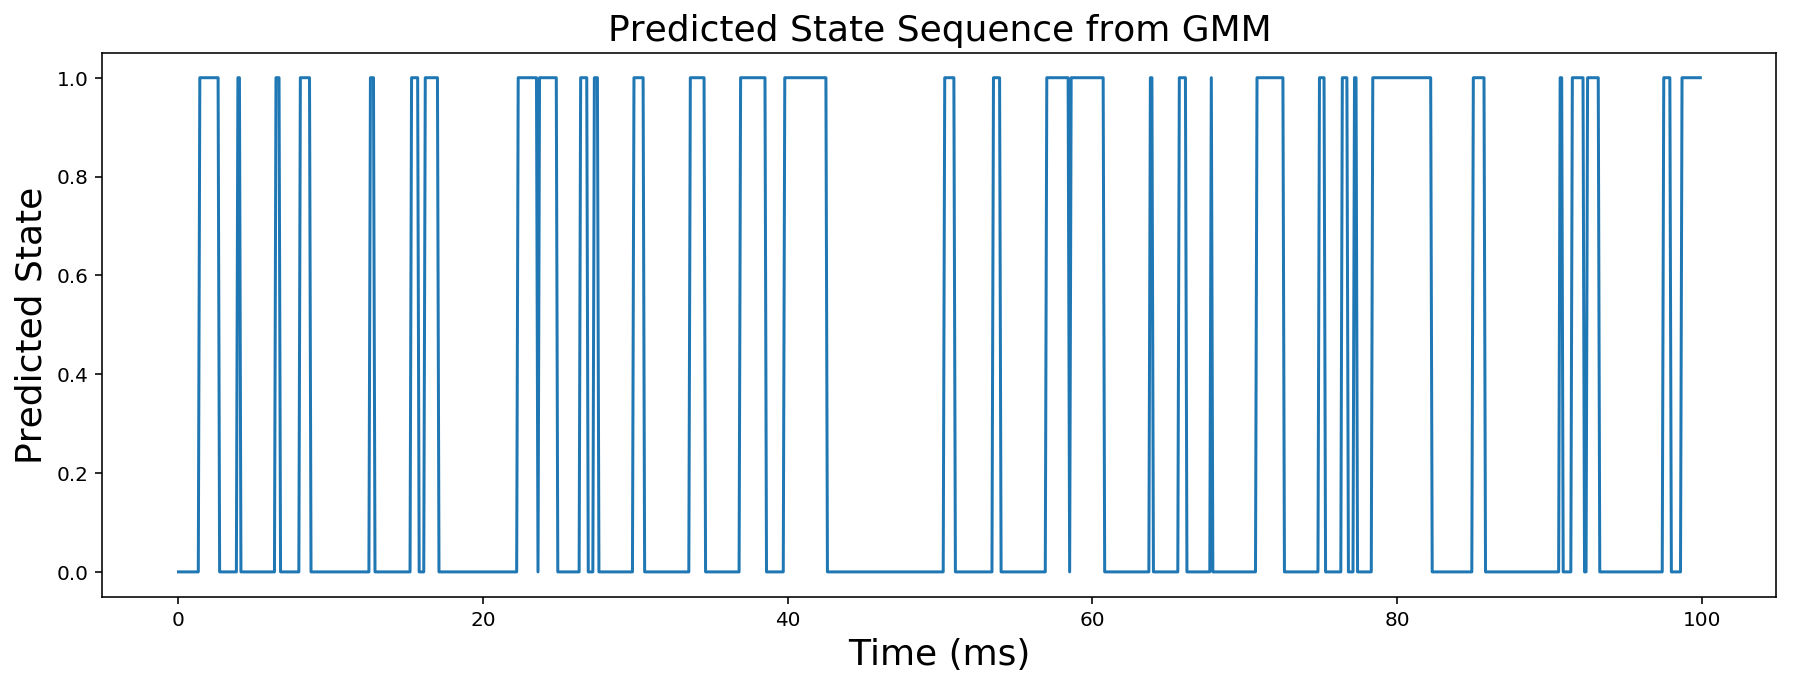

In [32]:
# plot the predicted sequence
plt.plot(time_ms, gmm_predicted_state_seq)
plt.xlabel('Time (ms)')
plt.ylabel('Predicted State')
plt.title('Predicted State Sequence from GMM');

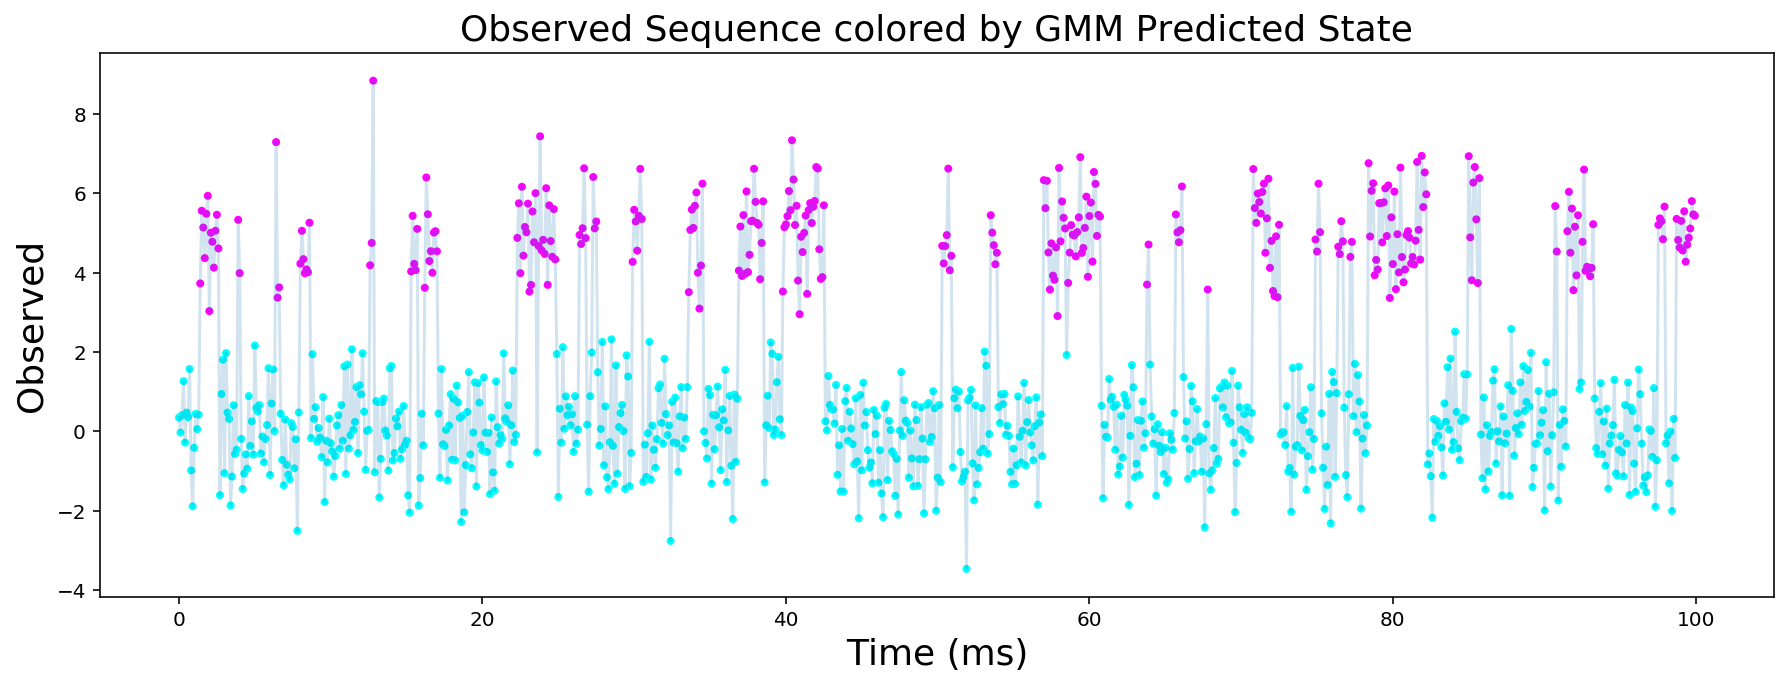

In [33]:
# plot the observed sequence
# with data points colored by their predicted state
plt.plot(time_ms, observed_seq, alpha=0.2)
plt.scatter(time_ms, observed_seq, marker='.', c=gmm_predicted_state_seq, cmap='cool')
plt.xlabel('Time (ms)')
plt.ylabel('Observed')
plt.title('Observed Sequence colored by GMM Predicted State');

## <font color=red>Exercises</font>

1. Look at the simulated single channel recording below. How many amplitude levels do you think there are?
2. Apply a GMM to predict the sequence of idealized amplitude levels.
3. Plot the first 1000 time points of the recording with data points colored by predicted amplitude level.

In [34]:
import pickle

with open("single_channel.dat", "rb") as f:
    time_ms, current_pA = pickle.load(f)

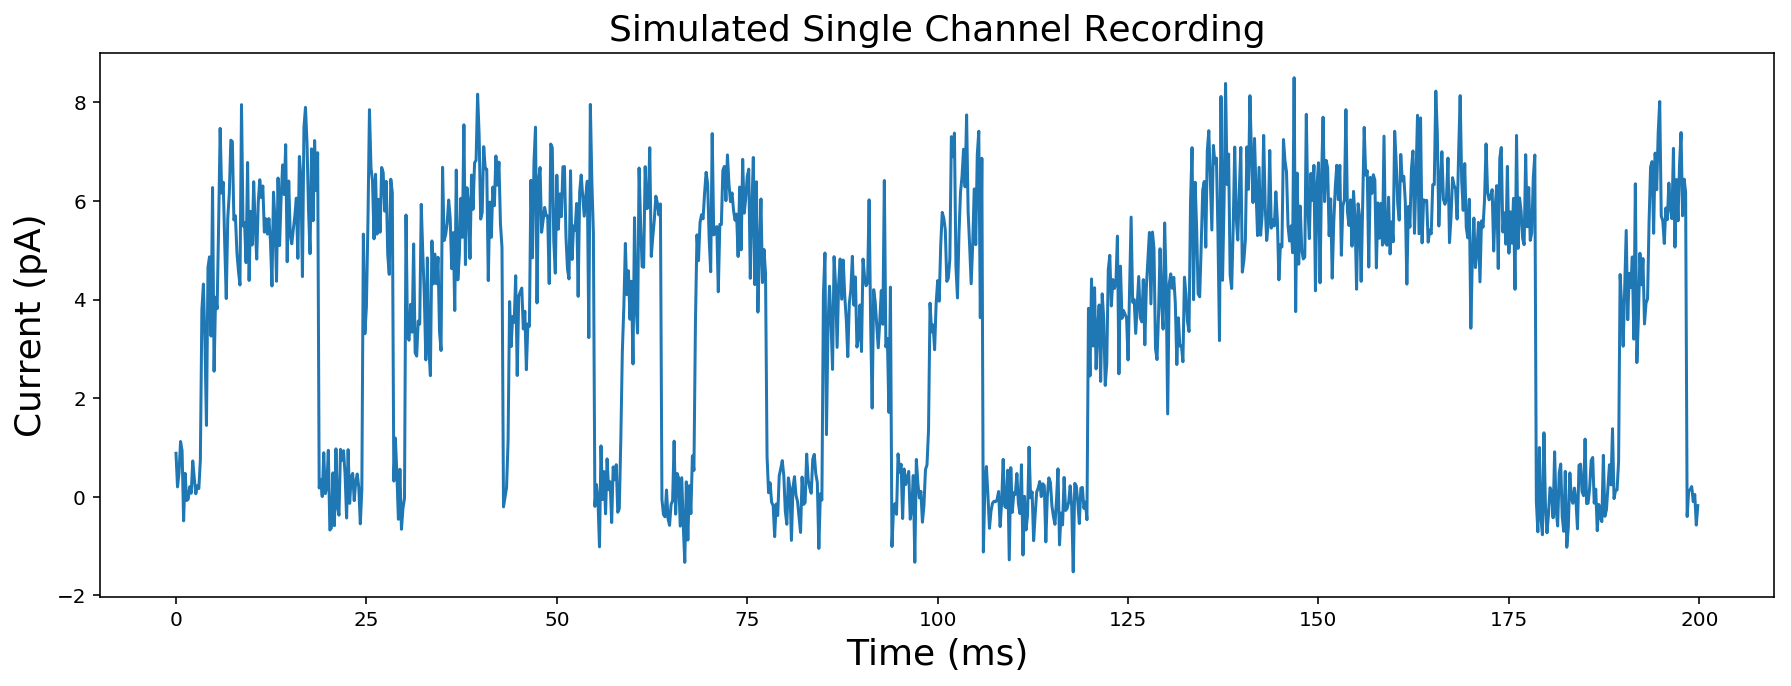

In [37]:
# plot the first 1000 time points of the loaded single channel record
n = 1000
plt.plot(time_ms[:n], current_pA[:n])
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Simulated Single Channel Recording');